This is just for starting the python script. No need to include it in the code

In [300]:
# Import the modules and packages we will use
import json
import os
from datetime import datetime
from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%load_ext blackcellmagic


plt.style.use(['science', 'nature'])
dotenv.load_dotenv()


The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


True

Here we are configuring the script

In [301]:
# Define GLOBAL variables

# Set the airport of interest to ORD (O'Hare International Airport)
AIRPORT_OF_INTEREST = "ORD"

#### PATHS AND DIRECTORIES
ROOT = Path(".")  # root path (the directory of the project folder)

# Where to store the input data
DATA_FOLDER = "data"
RAW_DATA_FOLDER = "raw"
RAW_FLIGHTS_DATA_FOLDER = "flights"
PROCESSED_DATA_FOLDER = "processed"
OUTPUT_DATA_FOLDER = "output"

DATA_PATH = ROOT / DATA_FOLDER

if not Path.exists(DATA_PATH):
    raise FileNotFoundError(f"The data folder does not exist: {DATA_PATH}")

RAW_DATA_PATH = DATA_PATH / RAW_DATA_FOLDER

if not Path.exists(RAW_DATA_PATH):
    raise FileNotFoundError(f"The raw data folder does not exist: {RAW_DATA_PATH}")

RAW_FLIGHTS_DATA_PATH = DATA_PATH / RAW_DATA_FOLDER / RAW_FLIGHTS_DATA_FOLDER

if not Path.exists(RAW_FLIGHTS_DATA_PATH):
    raise FileNotFoundError(
        f"The raw flights data folder does not exist: {RAW_FLIGHT_DATA_PATH}"
    )

PROCESSED_DATA_PATH = DATA_PATH / PROCESSED_DATA_FOLDER
Path.mkdir(PROCESSED_DATA_PATH, parents=True, exist_ok=True)

OUTPUT_DATA_PATH = DATA_PATH / OUTPUT_DATA_FOLDER
Path.mkdir(OUTPUT_DATA_PATH, parents=True, exist_ok=True)

# Name of the HDF5 file containing the data
HDF5_FILE = "flight_data.h5"

# Name of the CSV file containing the airport codes
AIRPORT_CODES_FILE = "airport_codes.csv"

# Name of the JSON file containing the weather daata
WEATHER_FILE = "ORD-weather-2009-2018.json"

##  1. Process the flight data

The data we downloaded from [“Airline Delay and Cancellation Data 2009 - 2018” Kaggle dataset](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018). It is in the folder `data/raw/flights` separated by year. It includes all the flights.

We need only the flights departing from Chicago Ohare (ORD), so we join (concatenate) all the csv folders into one big dataframe, and then filter the dataframe to only include flights departing from Chicago Ohare (ORD).

In [302]:
def process_flight_data(
    raw_flights_data_path: Path = RAW_FLIGHTS_DATA_PATH,
    processed_data_path: Path = PROCESSED_DATA_PATH,
    hdf5_file: str = HDF5_FILE, key=f"ORIGIN:{AIRPORT_OF_INTEREST}"
):
    
    def load_csv_files(files: list) -> pd.DataFrame:
        li = []  # where to store each csv file as a dataframe
        for filename in csv_files.__iter__():
            df = pd.read_csv(filename, index_col=None, header=0)
            li.append(df)
        return pd.concat(li, axis=0, ignore_index=True)

    # Try to load the HDF5 file
    try:
        df = pd.read_hdf(processed_data_path / hdf5_file, key=key)
    except (FileNotFoundError, KeyError): # if it does not exist, or key is wrong, create it
        # Get all the CSV Files
        csv_files = sorted(raw_flights_data_path.glob("*.csv"))
        
        print(f"Loading files, this may take a while...")
        df = load_csv_files(csv_files)
        
        # filter the dataframe
        df = df[df["ORIGIN"] == AIRPORT_OF_INTEREST]
        # save dataframe to HDF5 file
        df.to_hdf(processed_data_path / hdf5_file, key=key, mode="w", index=False)
    
    return df.reset_index(drop=True) # return the dataframe

df_flights = process_flight_data()

print("Dataframe loaded and filtered, lets look at the first rows to understand what we are doing")
df_flights.head()

Dataframe loaded and filtered, lets look at the first rows to understand what we are doing


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,XE,1232,ORD,EWR,905.0,900.0,-5.0,16.0,916.0,...,127.0,110.0,88.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,XE,1234,ORD,EWR,1230.0,1234.0,4.0,8.0,1242.0,...,149.0,111.0,89.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01,XE,1236,ORD,EWR,1630.0,1619.0,-11.0,19.0,1638.0,...,152.0,142.0,88.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01,XE,2647,ORD,IAH,1205.0,1154.0,-11.0,15.0,1209.0,...,180.0,163.0,142.0,925.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,XE,2865,ORD,IAH,1500.0,1453.0,-7.0,11.0,1504.0,...,174.0,159.0,136.0,925.0,NaN,NaN,NaN,NaN,NaN,NaN


Let's look at the data columns we have

In [303]:
df_flights.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

in prettier format:

|         Name        |                                                 Description                                                |   Type(Format)  |   Example  |
|:-------------------:|:----------------------------------------------------------------------------------------------------------:|:---------------:|:----------:|
|       FL_DATE       |                                             Date of the flight                                             | DATE (yy/mm/dd) | 2009-05-02 |
|      OP_CARRIER     |                                             Airline Identifier                                             |      STRING     |     9E     |
|  OP_CARRIER_FL_NUM  |                                                Flight Number                                               |     INTEGER     |    2216    |
|        ORIGIN       |                                      Starting Airport Code (IATA Code)                                     |      STRING     |     MLI    |
|         DEST        |                                    Destination Airport Code (IATA Code)                                    |      STRING     |     MEM    |
|     CRS_DEP_TIME    |                                           Planned Departure Time                                           |     INTEGER     |     600    |
|       DEP_TIME      |                                            Actual Departure Time                                           |      FLOAT      |    603.0   |
|      DEP_DELAY      |                                     Total Delay on Departure in minutes                                    |      FLOAT      |     3.0    |
|       TAXI_OUT      |           The time duration elapsed between departure from the origin airport gate and wheels off          |      FLOAT      |    14.0    |
|      WHEELS_OFF     |                         The time point that the aircraft’s wheels leave the ground                         |      FLOAT      |    617.0   |
|      WHEELS_ON      |                        The time point that the aircraft’s wheels touch on the ground                       |      FLOAT      |    757.0   |
|       TAXI_IN       |           The time duration elapsed between wheels-on and gate arrival at the destination airport          |      FLOAT      |     8.0    |
|     CRS_ARR_TIME    |                                            Planned arrival time                                            |     INTEGER     |     732    |
|       ARR_TIME      |                                             Actual Arrival Time                                            |      FLOAT      |    805.0   |
|      ARR_DELAY      |                                      Total Delay on Arrival in minutes                                     |      FLOAT      |    33.0    |
|      CANCELLED      |                                      Flight Cancelled (1 = cancelled)                                      |      FLOAT      |     0.0    |

## We need to get the weather data

[The data comes from VisualCrossing](https://visualcrossing.com/account).We have a file in `data/raw/` called `ORD-weather-2009-2018.json` which contains the weather data for Chicago Ohare (ORD) for all the years 2009-2018.

In [304]:
def process_weather_data(
    raw_weather_data: Path = RAW_DATA_PATH / WEATHER_FILE,
    processed_data_path: Path = PROCESSED_DATA_PATH,
    hdf5_file: str = "ord_weather.h5",
    key=f"WEATHER:{AIRPORT_OF_INTEREST}",
):
    def load_json_file(files: list) -> pd.DataFrame:
        data = json.load(open(raw_weather_data))

        li = []  # where to store each csv file as a dataframe

        for day in data["days"]:
            df = pd.DataFrame(day["hours"])
            # do some transformations
            df.rename(
                columns={"datetime": "time", "datetimeEpoch": "date"}, inplace=True
            )

            df["date"] = df["date"].apply(
                lambda x: (pd.to_datetime(datetime.fromtimestamp(x)))
            )
            df["date"] = df["date"].dt.date
            li.append(df)

        return pd.concat(li, axis=0, ignore_index=True)

    # Try to load the HDF5 file
    try:
        df = pd.read_hdf(processed_data_path / hdf5_file, key=key)
    except (
        FileNotFoundError,
        KeyError,
    ):  # if it does not exist, or key is wrong, create it
        # Get all the CSV Files

        print(f"Loading files, this may take a while...")
        df = load_json_file(RAW_DATA_PATH / WEATHER_FILE)

        # save dataframe to HDF5 file
        df.to_hdf(processed_data_path / hdf5_file, key=key, mode="w", index=False)

    return df  # return the dataframe


df_weather = process_weather_data()

Lets look at how the data looks

In [305]:
df_weather.head()

,time,date,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,icon,stations,source,tzoffset
0,00:00:00,2009-01-01,-8.3,-13.6,66.89,-13.4,0.0,None,None,None,...,16.0,88.0,None,None,0.0,Partially cloudy,partly-cloudy-night,"[72534014819, 72530094846, 74466504838]",obs,NaN
1,01:00:00,2009-01-01,-8.2,-14.7,66.58,-13.4,0.0,None,None,None,...,16.0,88.0,None,None,0.0,Partially cloudy,partly-cloudy-night,"[72534014819, 72530094846, 74466504838]",obs,NaN
2,02:00:00,2009-01-01,-7.8,-14.6,66.38,-13.0,0.0,None,None,None,...,16.0,91.6,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN
3,03:00:00,2009-01-01,-7.1,-14.3,67.03,-12.2,0.0,None,None,None,...,16.0,100.0,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN
4,04:00:00,2009-01-01,-7.1,-13.9,69.46,-11.8,0.0,None,None,None,...,16.0,100.0,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN


This are the columns of data we have

In [306]:
df_weather.columns

Index(['time', 'date', 'temp', 'feelslike', 'humidity', 'dew', 'precip',
       'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust',
       'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
       'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon',
       'stations', 'source', 'tzoffset'],
      dtype='object')

A summary of the data

In [307]:
df_weather.describe()

,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover,uvindex,tzoffset
count,87648.000000,87648.000000,87648.000000,87648.000000,87641.000000,87648.000000,87310.000000,87647.000000,87648.000000,87648.000000,87648.0,57110.0
mean,10.600452,8.706654,67.513745,4.273025,0.114299,15.209802,187.244348,1016.451836,14.617897,65.547010,0.0,-5.0
std,11.541020,13.909802,16.995718,10.723695,0.837129,8.406331,108.078392,7.525111,3.335163,35.153918,0.0,0.0
min,-27.100000,-41.000000,13.610000,-32.800000,0.000000,0.000000,0.000000,979.500000,0.000000,0.000000,0.0,-5.0
25%,1.700000,-2.100000,55.520000,-3.200000,0.000000,9.300000,83.000000,1011.800000,15.800000,28.400000,0.0,-5.0
50%,11.000000,11.000000,68.820000,4.500000,0.000000,14.400000,203.000000,1016.300000,16.000000,81.800000,0.0,-5.0
75%,20.100000,20.100000,80.830000,13.100000,0.000000,20.400000,278.000000,1021.100000,16.000000,99.400000,0.0,-5.0
max,39.100000,43.300000,100.000000,26.000000,72.830000,64.800000,360.000000,1043.900000,17.900000,100.000000,0.0,-5.0


## Now we need to merge the data.

But first we need to process the flights df and weather df to match the time and dates when joining

In [308]:
df_flights.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

Looking at the data, the time columns on `df_flighs` like `CRS_DEP_TIME` and `DEP_TIME` are in the complete time format HHMM, while the weather data has one datapoint at each hour HH:00. What we are going to do is create new columns rounding up the time columns on `df_flights` to the floor hour (trim hour) and then merge the two dataframes.

The modified time columns will have the suffix `_hour`

`df_flights`

In [309]:
df_flight_time_cols = ["CRS_DEP_TIME", "DEP_TIME", "CRS_ARR_TIME", "ARR_TIME"]

for col in df_flight_time_cols:
    print("Working on column:", col)
    df_flights[col] = df_flights[col].fillna(0)
    col_and_suffix = col + "_hour"
    df_flights[col_and_suffix] = (df_flights[col] / 100).astype(int)


# duplicate some columns and rename to match the weather df
df_flights["date"] = pd.to_datetime(df_flights["FL_DATE"]).dt.date
df_flights["time_hour"] = df_flights.CRS_DEP_TIME_hour

Working on column: CRS_DEP_TIME
Working on column: DEP_TIME
Working on column: CRS_ARR_TIME
Working on column: ARR_TIME


`df_weather`

In [310]:
df_weather['time_hour'] = pd.to_datetime(df_weather['time']).dt.strftime('%H').astype(int)

Merge the dataframes

In [311]:
df = pd.merge(df_flights, df_weather, on=['date', 'time_hour'])

Let's look at the columns

In [312]:
df.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27', 'CRS_DEP_TIME_hour', 'DEP_TIME_hour',
       'CRS_ARR_TIME_hour', 'ARR_TIME_hour', 'date', 'time_hour', 'time',
       'temp', 'feelslike', 'humidity', 'dew', 'precip', 'precipprob', 'snow',
       'snowdepth', 'preciptype', 'windgust', 'windspeed', 'winddir',
       'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy',
       'uvindex', 'conditions', 'icon', 'stations', 'source', 'tzoffset'],
      dtype='object')

So there's a few columns that we don't need or are duplicated.

The ones we need to remove are:
- `FL_DATE` - we already have `date` column
- `ORIGIN` - they all are coming out of ORD
- `WHEELS_ON`, `WHEELS_OFF`, `TAXI_IN`, `CRS_ARR_TIME`, `ARR_TIME`, `ARR_DELAY` - this happen after the even of delay
- The types of delay: `SECURITY_DELAY`, etc...
- `Unnamed: 27`, `ACTUAL_ELAPSED_TIME`, `AIR_TIME`, `DISTANCE`, `CRS_ARR_TIME_hour`, `ARR_TIME_hour`, `CANCELLATION_CODE`, `DIVERTED`, `CRS_ELAPSED_TIME` - there are not useful or we already discarded them
- `solarradiation`, `solarenergy`, `uvindex`, `icon`, `stations`, `source`, `conditions`, `tzoffset`
- `precipprob`, `snow`, `snowdepth`, `preciptype`, `windgust` -> this have little data

In [313]:
df_cleaned = df.copy(deep=True)
df_cleaned = df_cleaned.drop(
    [
        "FL_DATE",
        "ORIGIN",
        "WHEELS_ON",
        "WHEELS_OFF",
        "TAXI_IN",
        "TAXI_OUT",
        "CARRIER_DELAY",
        "CANCELLATION_CODE",
        "CRS_ARR_TIME",
        "ARR_TIME",
        "ARR_DELAY",
        "SECURITY_DELAY",
        "CRS_ELAPSED_TIME",
        "WEATHER_DELAY",
        "NAS_DELAY",
        "LATE_AIRCRAFT_DELAY",
        "Unnamed: 27",
        "ACTUAL_ELAPSED_TIME",
        "AIR_TIME",
        "DISTANCE",
        "CRS_ARR_TIME_hour",
        "DIVERTED",
        "ARR_TIME_hour",
        "solarradiation",
        "solarenergy",
        "uvindex",
        "icon",
        "stations",
        "source",
        "conditions",
        "tzoffset",
        "precipprob",
        "snow",
        "snowdepth",
        "preciptype",
        "windgust",
        "OP_CARRIER_FL_NUM"
    ],
    axis=1,
)

del df, df_flights, df_weather  # delete the dataframes to free up memory

df_cleaned.head()

,OP_CARRIER,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CANCELLED,CRS_DEP_TIME_hour,DEP_TIME_hour,date,time_hour,...,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover
0,XE,EWR,905.0,900.0,-5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
1,YV,CHS,910.0,905.0,-5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
2,YV,COS,941.0,939.0,-2.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
3,YV,ORF,920.0,925.0,5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
4,OH,CVG,925.0,925.0,0.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2


- Create a column `DELAYED` if delay is greater than 0
- Create a column `DELAYED_20` if delay is greater than 20


In [314]:
df_cleaned['DELAYED'] = (df_cleaned['DEP_DELAY'] > 0).astype(int)
df_cleaned['DELAYED_20'] = (df_cleaned['DEP_DELAY'] >= 20).astype(int)

rearrange the columns. Remove `DEP_TIME` because we already have `DELAYED` and `DELAYED_20`

In [315]:
df_cleaned.columns

df_cleaned = df_cleaned[
    [
        "CANCELLED",
        "DELAYED",
        "DELAYED_20",
        "DEP_DELAY",
        "CRS_DEP_TIME",
        "date",
        "time",
        "OP_CARRIER",
        "DEST",        
        "temp",
        "feelslike",
        "humidity",
        "dew",
        "precip",
        "windspeed",
        "winddir",
        "pressure",
        "visibility",
        "cloudcover",
    ]
]


# modify the type of cancelled
df_cleaned.CANCELLED = df_cleaned.CANCELLED.astype(int)

df_cleaned.head()

,CANCELLED,DELAYED,DELAYED_20,DEP_DELAY,CRS_DEP_TIME,date,time,OP_CARRIER,DEST,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover
0,0,0,0,-5.0,905.0,2009-01-01,09:00:00,XE,EWR,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
1,0,0,0,-5.0,910.0,2009-01-01,09:00:00,YV,CHS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
2,0,0,0,-2.0,941.0,2009-01-01,09:00:00,YV,COS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
3,0,1,0,5.0,920.0,2009-01-01,09:00:00,YV,ORF,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
4,0,0,0,0.0,925.0,2009-01-01,09:00:00,OH,CVG,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2


for the date, add a column `day`, `month`, `weekday`, `quarter`, `is_holiday`, `is_weekend`

In [316]:
# set up type
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

# set up for holiday calendar
cal = calendar()
holidays = cal.holidays(start=df_cleaned['date'].min(), end=df_cleaned['date'].max())


df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['weekday'] = df_cleaned['date'].dt.dayofweek + 1
df_cleaned['quarter'] = df_cleaned['date'].dt.quarter
df_cleaned['is_holiday'] = df_cleaned['date'].isin(holidays).astype(int)
df_cleaned['is_weekend'] = (df_cleaned['weekday'] > 5).astype(int)

### theres a few outliers precip so lets remove them

In [318]:

df_cleaned = df_cleaned[df_cleaned.precip < 30]

Finally, drop the date and time column


In [319]:
df_cleaned.drop(['date', 'time'], axis=1, inplace=True)

# FINALLY we can start the analysis

## Remember, we are focusing on prediction, not on inference on this analysis

### I'm also saving a sample of the dataframe as an excel file so you can open it in case you have any issues

In [320]:
df_cleaned.sample(100000).to_excel(OUTPUT_DATA_PATH / 'cleaned_data.xlsx', index=False)

we first set up different Y, for different predictions. Then drop them from 

In [321]:
Y_delayed = df_cleaned['DELAYED']
Y_delay_time = df_cleaned['DEP_DELAY']
Y_delayed_20 = df_cleaned['DELAYED_20']
Y_cancelled = df_cleaned['CANCELLED']


Let's make a dataframe with all the potential independent variables without the Y variables we set above

In [322]:
X = df_cleaned.drop(['DELAYED', 'DELAYED_20', 'CANCELLED', 'DEP_DELAY'], axis=1)
# there are some empty values on windidir, so we will fill them with 0
X.winddir.fillna(0, inplace=True)
X.head()

,CRS_DEP_TIME,OP_CARRIER,DEST,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover,month,weekday,quarter,is_holiday,is_weekend
0,905.0,XE,EWR,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2,1,4,1,1,0
1,910.0,YV,CHS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2,1,4,1,1,0
2,941.0,YV,COS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2,1,4,1,1,0
3,920.0,YV,ORF,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2,1,4,1,1,0
4,925.0,OH,CVG,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2,1,4,1,1,0


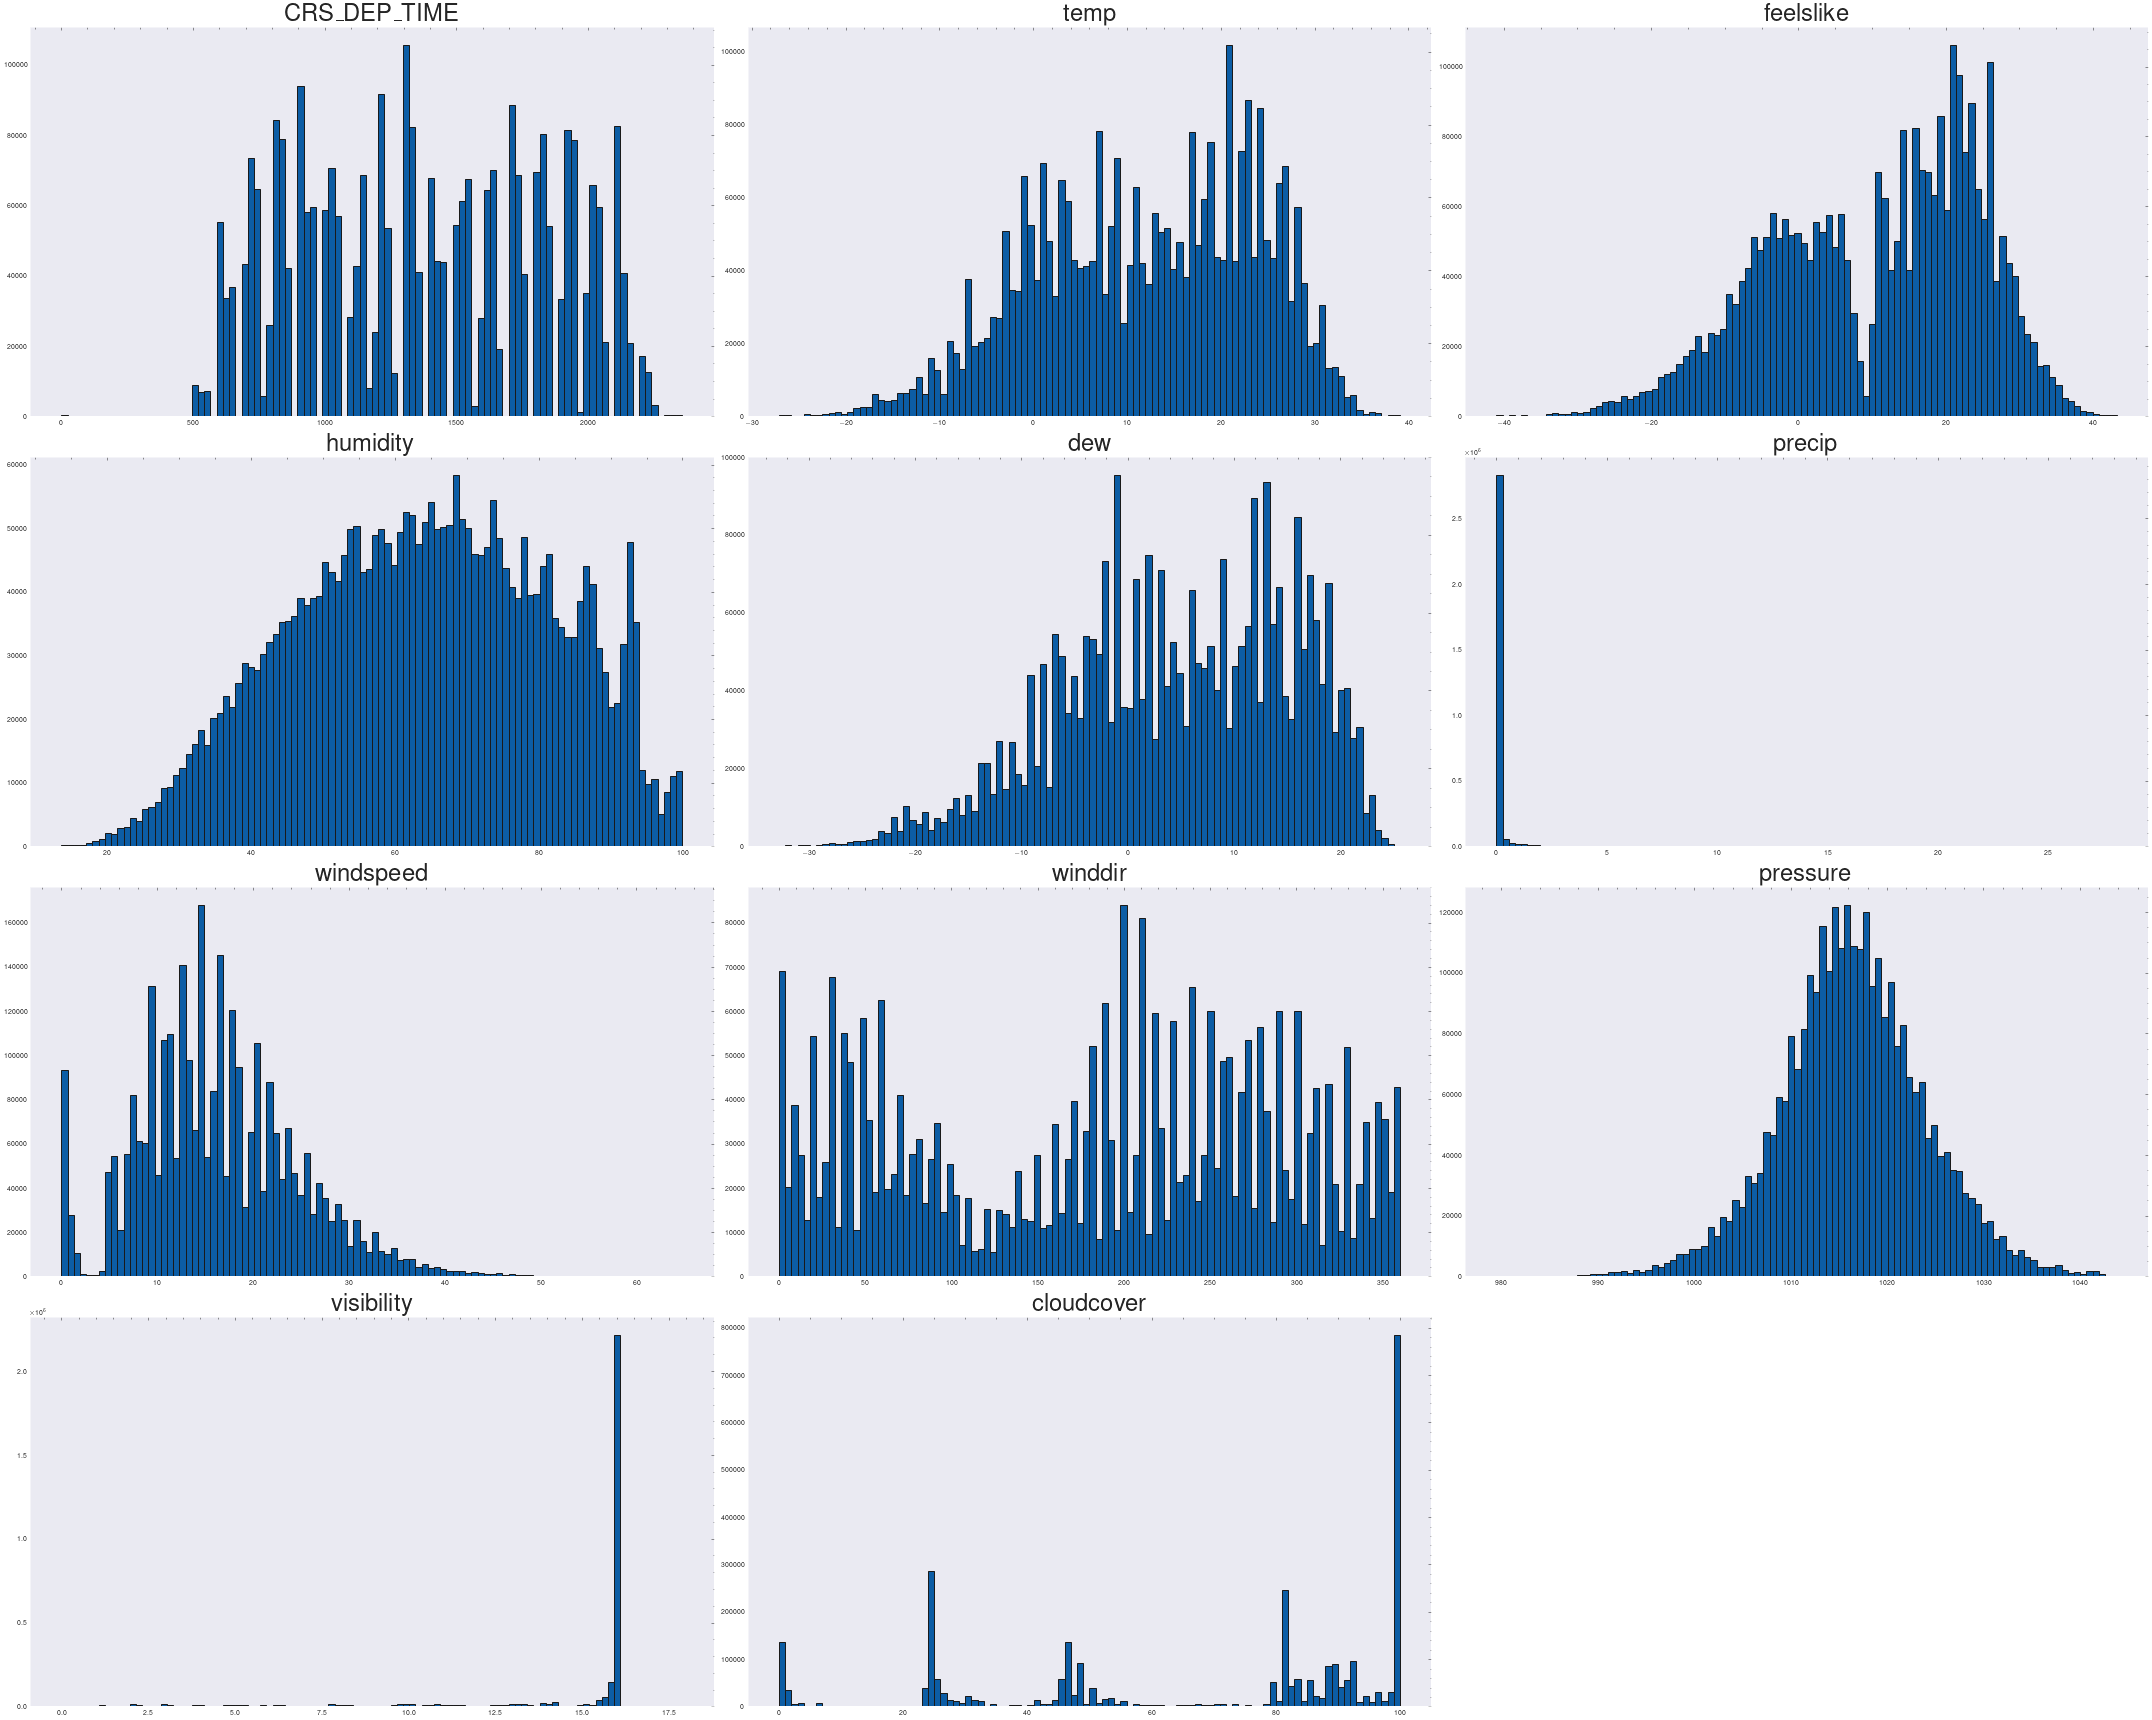

In [323]:
X.hist(column=['CRS_DEP_TIME', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover'], bins=100, grid=False, figsize=(30, 24), ec='k')
plt.tight_layout()
plt.show()


the precip looks like that because

In [324]:
df_cleaned.precip.describe()

count    3.001025e+06
mean     1.077018e-01
std      7.277306e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.814000e+01
Name: precip, dtype: float64

In [325]:
sns.set(font_scale = 2)
sns.pairplot(df_cleaned.sample(1000).loc[:, ['DELAYED', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover']], hue='DELAYED')

## Linear Regression

even though we are doing prediction analysis, we might as well start with inference for delay time with a linear regression.

transform categoricals to dummies

In [ ]:


# get dummies
# dummy cols
dummies = ['OP_CARRIER', 'DEST', 'day', 'month', 'weekday', 'is_holiday', 'is_weekend']
X_w_dummies = pd.get_dummies(X, columns=dummies, drop_first=True)
X_w_dummies.head()


,CRS_DEP_TIME,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,...,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,is_holiday_1,is_weekend_1
0,905.0,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,...,0,0,0,0,1,0,0,0,1,0
1,910.0,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,...,0,0,0,0,1,0,0,0,1,0
2,941.0,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,...,0,0,0,0,1,0,0,0,1,0
3,920.0,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,...,0,0,0,0,1,0,0,0,1,0
4,925.0,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,...,0,0,0,0,1,0,0,0,1,0


In [298]:
import statsmodels.api as sm

sm.OLS(Y_delayed, sm.add_constant(X_w_dummies)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                DELAYED   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     793.6
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        13:00:04   Log-Likelihood:            -2.0146e+06
No. Observations:             3001025   AIC:                         4.030e+06
Df Residuals:                 3000757   BIC:                         4.033e+06
Df Model:                         267                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0900      0.052     20.974      0.000       0.988       1.192
CRS_DEP_TIME      0.0002   6.49e-07    272.048      0.000       0.000       0.000
temp              0.0138      0.000     31.825      0.000       0.013       0.015
feelslike        -0.0097      0.000    -39.259      0.000      -0.010      -0.009
humidity          0.0029   9.76e-05     29.763      0.000       0.003       0.003
dew              -0.0081      0.000    -21.923      0.000      -0.009      -0.007
precip            0.0143      0.000     36.094      0.000       0.013       0.015
windspeed         0.0023   4.24e-05     53.317      0.000       0.002       0.002
winddir        6.393e-05   2.76e-06     23.191      0.000    5.85e-05    6.93e-05
pressure         -0.0013   4.83e-05    -26.661      0.000      -0.001      -0.001
visibility       -0.0081      0.000    -70.876      0.000      -0.008      -0.008
cloudcover        0.0007   9.65e-06     68.321      0.000       0.001       0.001
OP_CARRIER_AA     0.0368      0.006      5.909      0.000       0.025       0.049
OP_CARRIER_AS    -0.1389      0.007    -18.816      0.000      -0.153      -0.124
OP_CARRIER_B6     0.0178      0.007      2.568      0.010       0.004       0.031
OP_CARRIER_CO     0.0709      0.007      9.703      0.000       0.057       0.085
OP_CARRIER_DL     0.0387      0.007      5.953      0.000       0.026       0.051
OP_CARRIER_EV     0.1143      0.006     18.279      0.000       0.102       0.127
OP_CARRIER_F9    -0.0117      0.007     -1.591      0.112      -0.026       0.003
OP_CARRIER_MQ     0.0670      0.006     10.796      0.000       0.055       0.079
OP_CARRIER_NK     0.0165      0.007      2.483      0.013       0.003       0.030
OP_CARRIER_NW    -0.0726      0.009     -8.112      0.000      -0.090      -0.055
OP_CARRIER_OH    -0.0116      0.008     -1.420      0.156      -0.028       0.004
OP_CARRIER_OO     0.0686      0.006     11.012      0.000       0.056       0.081
OP_CARRIER_UA     0.0486      0.006      7.811      0.000       0.036       0.061
OP_CARRIER_US    -0.0564      0.007     -8.418      0.000      -0.069      -0.043
OP_CARRIER_VX    -0.0924      0.008    -11.702      0.000      -0.108      -0.077
OP_CARRIER_XE     0.0743      0.006     11.572      0.000       0.062       0.087
OP_CARRIER_YV     0.0601      0.006      9.345      0.000       0.047       0.073
OP_CARRIER_YX    -0.0781      0.007    -10.950      0.000      -0.092      -0.064
DEST_ABQ          0.1029      0.008     13.281      0.000       0.088       0.118
DEST_ACY          0.1632      0.021      7.753      0.000       0.122       0.204
DEST_AGS         -0.0675      0.150     -0.451      0.652      -0.361       0.226
DEST_ALB          0.0556      0.007      8.324      0.000       0.042       0.069
DEST_ALO         -0.0526      0.009     -5.648   

In [295]:
linear_regression1.coef_

array([ 1.76447516e-04,  1.37911492e-02, -9.65720975e-03,  2.90536090e-03,
       -8.07183292e-03,  1.42643381e-02,  2.26239275e-03,  6.39345591e-05,
       -1.28715683e-03, -8.09789150e-03,  6.59203883e-04, -2.51004347e+07,
       -2.51004347e+07, -2.51004348e+07, -2.51004347e+07, -2.51004346e+07,
       -2.51004346e+07, -2.51004346e+07, -2.51004347e+07, -2.51004346e+07,
       -2.51004347e+07, -2.51004348e+07, -2.51004347e+07, -2.51004346e+07,
       -2.51004346e+07, -2.51004347e+07, -2.51004348e+07, -2.51004346e+07,
       -2.51004346e+07, -2.51004348e+07,  2.46742255e+05,  2.46742358e+05,
        2.46742418e+05,  2.46742188e+05,  2.46742311e+05,  2.46742202e+05,
        2.46742518e+05,  2.46742223e+05,  2.46742412e+05,  2.46742359e+05,
        2.46742227e+05,  2.46742330e+05,  2.46742273e+05,  2.46742269e+05,
        2.46742172e+05,  2.46742321e+05,  2.46742184e+05,  2.46742286e+05,
        2.46742275e+05,  2.46742281e+05,  2.46742195e+05,  2.46742307e+05,
        2.46742341e+05,  